# Domanda 14

Discutere la ricostruzione di un’immagine corrotta da blur, downsampling
e rumore, mostrando la soluzione naive, ottenuta risolvendo il problema dei minimi quadrati e la soluzione ottenuta con il metodo di regolarizzazione di Tikhonov. 

Mostrare inoltre le immagini ricostruite e i grafici dei parametri PSNR e MSE al variare del numero di iterazioni. 

Infine discutere i risultati al variare del parametro di regolarizzazione λ.

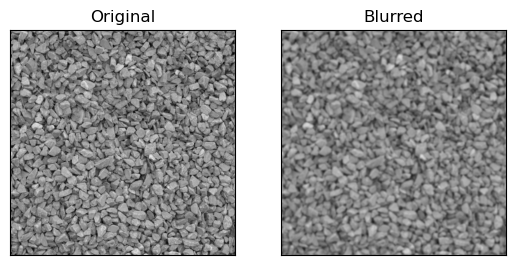

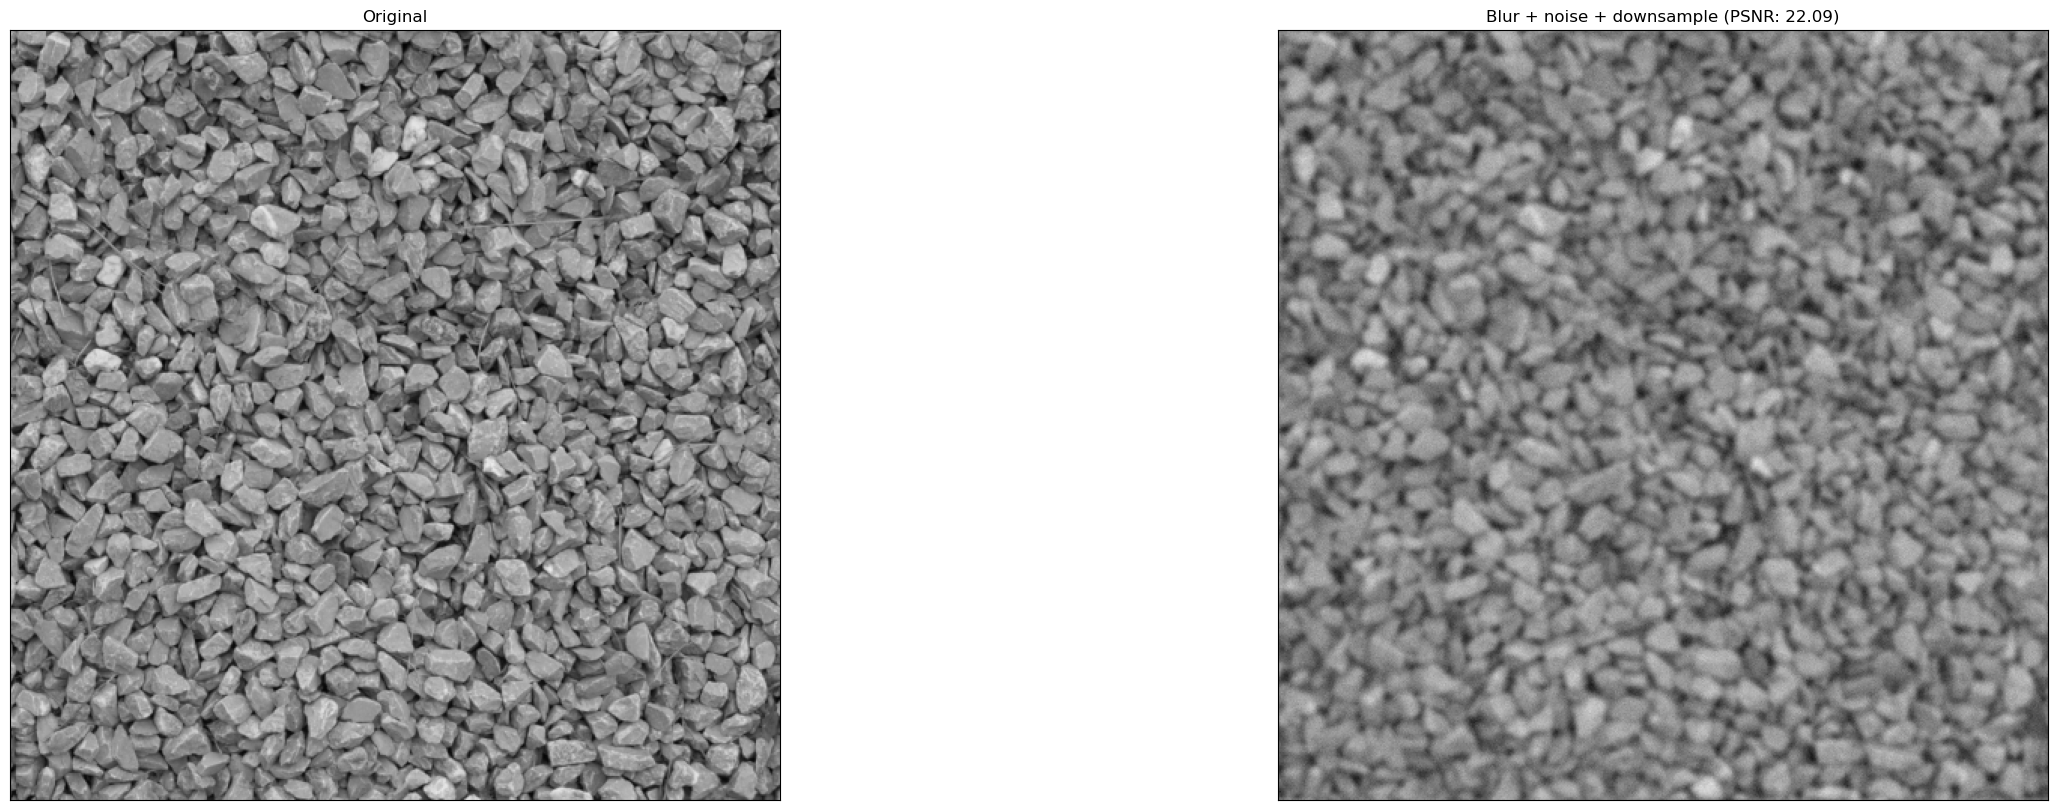

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft
from utils import psf_fft, A, AT, gaussian_kernel
from scipy.optimize import minimize

X = data.gravel().astype(np.float64)/255
m, n = X.shape
plt.show()

k = gaussian_kernel(24, 3)

X_blurred = cv.filter2D(X, -1, k)

K = psf_fft(k, 24, X.shape)

X_blurred = A(X, K)


plt.subplot(121).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122).imshow(X_blurred, cmap='gray', vmin=0, vmax=1)
plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()



K = psf_fft(k, 24, X.shape)
X_blurred = A(X, K)


scale_percent = 50
width = int(X_blurred.shape[1] * scale_percent / 100)
height = int(X_blurred.shape[0] * scale_percent / 100)
dim = (width, height)
resized = cv.resize(X_blurred, dim)

sigma = 0.02
np.random.seed(42)
noise = np.random.normal(size=X.shape) * sigma


y = X_blurred + noise
PSNR = metrics.peak_signal_noise_ratio(X, y)
mse = metrics.mean_squared_error(X, y)
ATy = AT(y, K)
plt.figure(figsize=(30, 10))
plt.subplot(121).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title(f'Blur + noise + downsample (PSNR: {PSNR:.2f})')
plt.xticks([]), plt.yticks([])
plt.show()



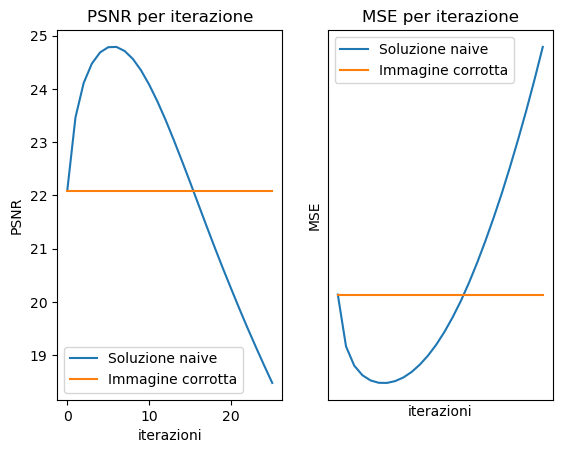

In [5]:
def f(x):
    x = x.reshape((m, n))
    Ax = A(x, K)
    return 0.5 * np.sum(np.square(Ax - y))


def df(x):
    x = x.reshape((m, n))
    ATAx = AT(A(x,K),K)
    d = ATAx - ATy
    return d.reshape(m * n)

x0 = y.reshape(m*n)
max_iter = 25

res = minimize(f, x0, method='CG', jac=df, options={'maxiter':max_iter, 'return_all':True})
PSNR = np.zeros(max_iter + 1)
mse = np.zeros(max_iter + 1)
for k, x_k in enumerate(res.allvecs):
    PSNR[k] = metrics.peak_signal_noise_ratio(X, x_k.reshape(X.shape))
    mse[k] = metrics.mean_squared_error(X, x_k.reshape(X.shape))

X_res = res.x.reshape((m, n))

starting_PSNR = np.full(PSNR.shape[0], metrics.peak_signal_noise_ratio(X, y))
starting_mse = np.full(mse.shape[0], metrics.mean_squared_error(X, y))

ax2 = plt.subplot(1, 2, 1)
ax2.plot(PSNR, label="Soluzione naive")
ax2.plot(starting_PSNR, label="Immagine corrotta")
plt.legend()
plt.title('PSNR per iterazione')
plt.ylabel("PSNR")
plt.xlabel('iterazioni')

ax3 = plt.subplot(1, 2, 2)
ax3.plot(mse, label="Soluzione naive")
ax3.plot(starting_mse, label="Immagine corrotta")
plt.legend()
plt.title('MSE per iterazione')
plt.ylabel("MSE")
plt.xlabel('iterazioni')
plt.xticks([]), plt.yticks([])
plt.show()


PSNR: 24.91 (λ = 0.01)
PSNR: 24.83 (λ = 0.03)
PSNR: 24.46 (λ = 0.04)
PSNR: 7.21 (λ = 5.00)


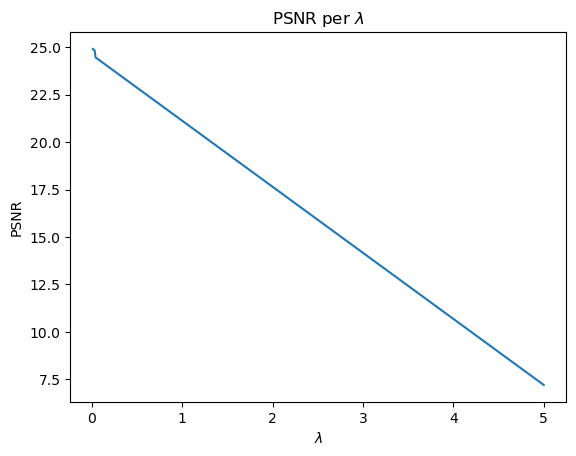

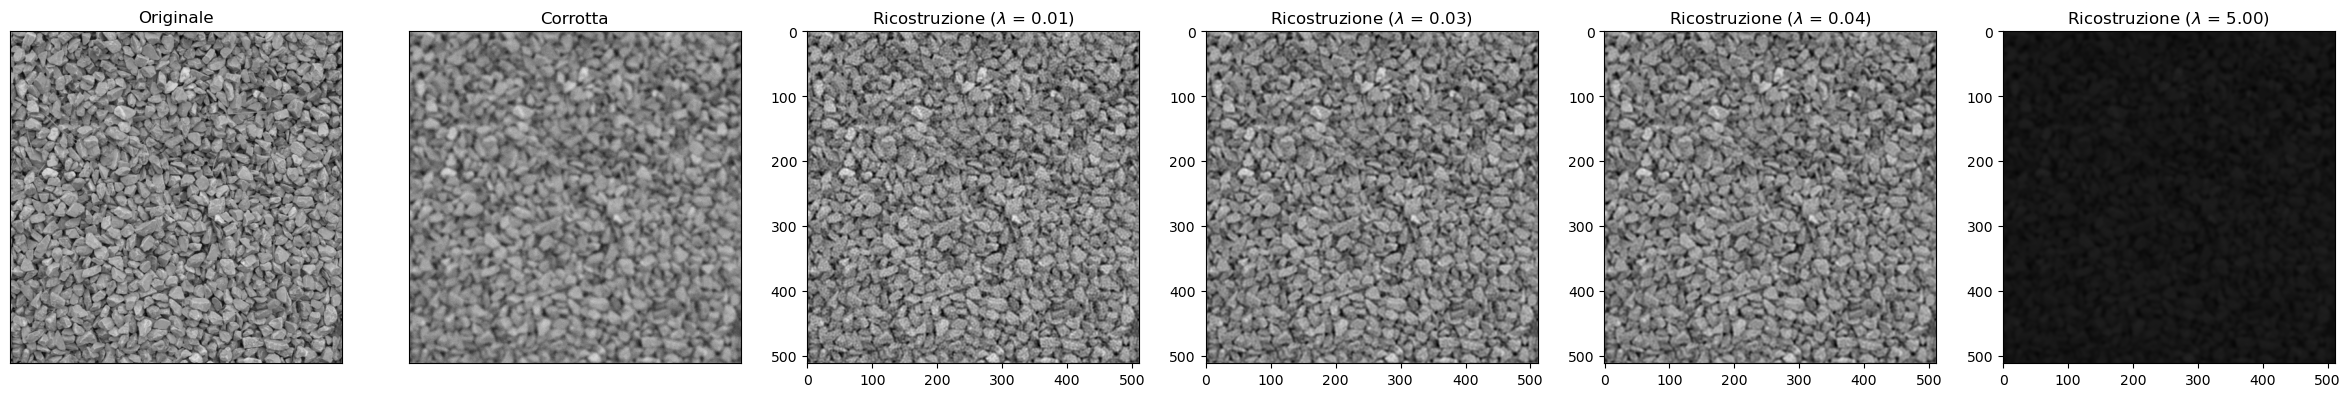

In [7]:
def f(x, L):
    nsq = np.sum(np.square(x))
    x = x.reshape((m, n))
    Ax = A(x, K)
    return 0.5 * np.sum(np.square(Ax - y)) + 0.5 * L * nsq


def df(x, L):
    Lx = L * x
    x = x.reshape(m, n)
    ATAx = AT(A(x,K),K)
    d = ATAx - ATy
    return d.reshape(m * n) + Lx


x0 = y.reshape(m*n)
lambdas = [0.01,0.03,0.04, 5.0]
PSNRs = []
images = []


for i, L in enumerate(lambdas):
    max_iter = 50
    res = minimize(f, x0, (L), method='CG', jac=df, options={'maxiter':max_iter})
    X_curr = res.x.reshape(X.shape)
    images.append(X_curr)
    PSNR = metrics.peak_signal_noise_ratio(X, X_curr)
    PSNRs.append(PSNR)
    print(f'PSNR: {PSNR:.2f} (\u03BB = {L:.2f})')

    
plt.plot(lambdas,PSNRs)
plt.title('PSNR per $\lambda$')
plt.ylabel("PSNR")
plt.xlabel('$\lambda$')
plt.show()


plt.figure(figsize=(30, 10))
plt.subplot(1, len(lambdas) + 2, 1).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title("Originale")
plt.xticks([]), plt.yticks([])
plt.subplot(1, len(lambdas) + 2, 2).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title("Corrotta")
plt.xticks([]), plt.yticks([])


for i, L in enumerate(lambdas):
    plt.subplot(1, len(lambdas) + 2, i + 3).imshow(images[i], cmap='gray',vmin=0, vmax=1)
    plt.title(f"Ricostruzione ($\lambda$ = {L:.2f})")
plt.show()